# ENSO Metrics Portrait Plot

## Import mododules

In [1]:
import tempfile
import base64

import glob
import json
import os
import sys
import genutil

import vcs
import MV2
import pcmdi_metrics
import pcmdi_metrics.graphics.portraits

## Set up VCS Canvas

In [2]:
class VCSAddonsNotebook(object):
    def __init__(self,x):
        self.x = x
    def _repr_png_(self):
        fnm = tempfile.mktemp()+".png"
        self.x.png(fnm)
        encoded = base64.b64encode(open(fnm, "rb").read())
        return encoded
    def __call__(self):
        return self

In [3]:
# VCS Canvas
x=vcs.init(bg=True,geometry=(1200,600))

show = VCSAddonsNotebook(x)

# Load our "pretty" colormap
x.scriptrun(
    os.path.join(
        sys.prefix,
        "share",
        "pmp",
        "graphics",
        'vcs',
        'portraits.scr'))

#x.setcolormap("bl_rd_12")
x.setcolormap("blue2orange")

## Data Read In -- 1) Axis read in

In [4]:
json_file = 'test_MC1_all_reformatted.json'
json_files = [json_file]

print "We are looking at {:d} Json Files:".format(len(json_files))
J = pcmdi_metrics.io.base.JSONs(json_files)

We are looking at 1 Json Files:


In [5]:
print J.getAxisIds()

['variable', u'metric', u'model', u'type', u'source', u'statistic']


In [6]:
models_list = sorted(J.getAxis("model")[:], key=lambda s:s.lower())
#models_list.remove("observations")
print models_list, len(models_list)


[u'ACCESS1-0', u'ACCESS1-3', u'CanESM2', u'CCSM4', u'CESM1-BGC', u'CESM1-CAM5', u'CESM1-FASTCHEM', u'CESM1-WACCM', u'CNRM-CM5', u'CNRM-CM5-2', u'INMCM4', u'IPSL-CM5A-LR', u'IPSL-CM5A-MR', u'IPSL-CM5B-LR', u'MPI-ESM-LR', u'MPI-ESM-MR', u'MPI-ESM-P', u'NorESM1-M', u'NorESM1-ME'] 19


In [7]:
metrics_list = sorted(J.getAxis("metric")[:], key=lambda s:s.lower())
print metrics_list, len(metrics_list)

[u'EnsoAlphaLhf', u'EnsoAlphaLwr', u'EnsoAlphaShf', u'EnsoAlphaSwr', u'EnsoAlphaThf', u'EnsoAmpl', u'EnsoMu', u'EnsoRmse', u'EnsoSeasonality'] 9


In [8]:
sources_list = sorted(J.getAxis("source")[:], key=lambda s:s.lower())
print sources_list, len(sources_list)
sources_list.remove("model")

[u'HadISST', u'HadISST_Tropflux', u'model', u'Tropflux', u'Tropflux_Tropflux'] 5


## Data Read In -- 2) Read statistical values

In [10]:
# until we have a merge option!
hadisst =J(statistic=["value"],type=["metric"],source=["HadISST"],model=models_list,metric=metrics_list)(squeeze=1)
hadisst_trop =J(statistic=["value"],type=["metric"],source=["HadISST_Tropflux"],model=models_list,metric=metrics_list)(squeeze=1)
print hadisst.shape, hadisst_trop.shape
print hadisst.count(), hadisst_trop.count(),9*19
mask = hadisst.mask
rms_xy = MV2.where(mask, hadisst_trop, hadisst)
print rms_xy.count()

(9, 19) (9, 19)
57 114 171
171


## Normalize by median value (OBS NOT included for now)

test something

In [11]:
median = genutil.statistics.median(rms_xy,axis=1)[0]

print median
print median.shape

[-1.6925894832897654 -1.202416310462502 -1.5370104064629444
 -0.89637674310318 -1.410634207631612 0.09521373853258971
 -0.6257554856197094 2.06756863150553 -0.2357026084871674]
(9,)


/home/doutriaux1/anaconda2/envs/nightly2/lib/python2.7/site-packages/genutil/statistics.py:1712: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(ii) > 0:


In [12]:
#match shapes
rms_xy, median = genutil.grower(rms_xy,median)
print rms_xy.shape
print median.shape

#Loose info on median
median = median.filled()

# normalize
rms_xy = MV2.divide(MV2.subtract(rms_xy.filled(),median),median)

(9, 19)
(9, 19)


In [13]:
P = pcmdi_metrics.graphics.portraits.Portrait()
#P.PLOT_SETTINGS.colorm
xax = [s.encode('utf-8')+' ' for s in models_list]  # CHANGE FROM UNICODE TO BYTE STRINGS
yax = [s.encode('utf-8')+' ' for s in metrics_list]

## Plotting

In [14]:
# Preprocessing step to "decorate" the axis
P.decorate(rms_xy, yax, xax)

x.clear()

/home/doutriaux1/anaconda2/envs/nightly2/lib/python2.7/site-packages/vcs/VTKPlots.py:1024: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  data[:] = numpy.ma.masked_invalid(data, numpy.nan)


NPARAM: 3


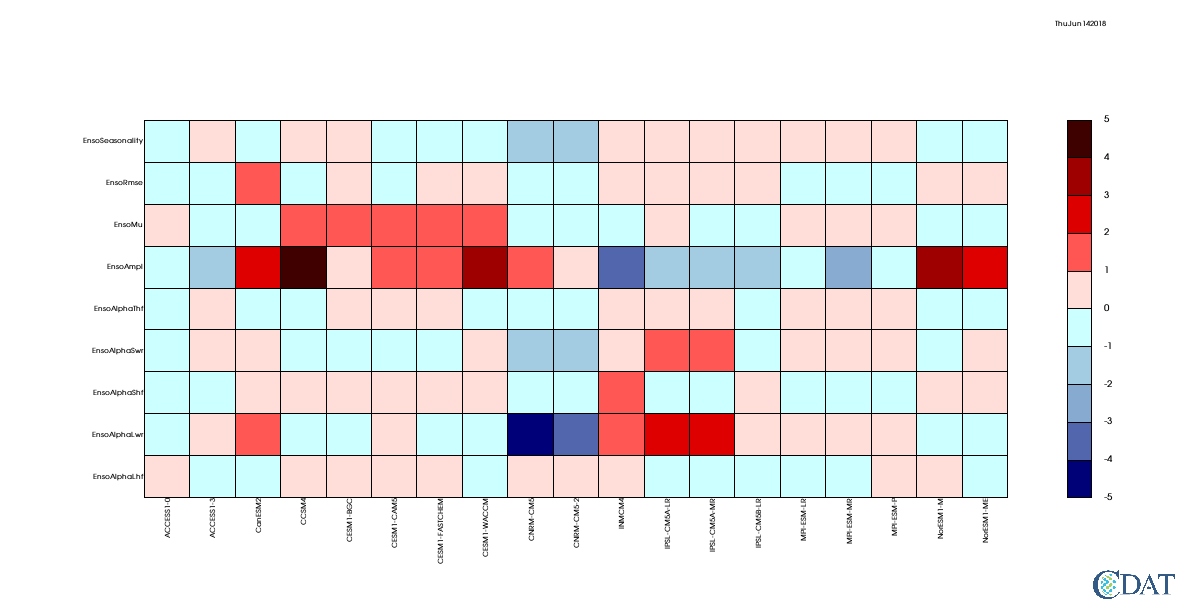

In [15]:
P.plot(rms_xy,x=x)

show()

## Customize plot

NPARAM: 3


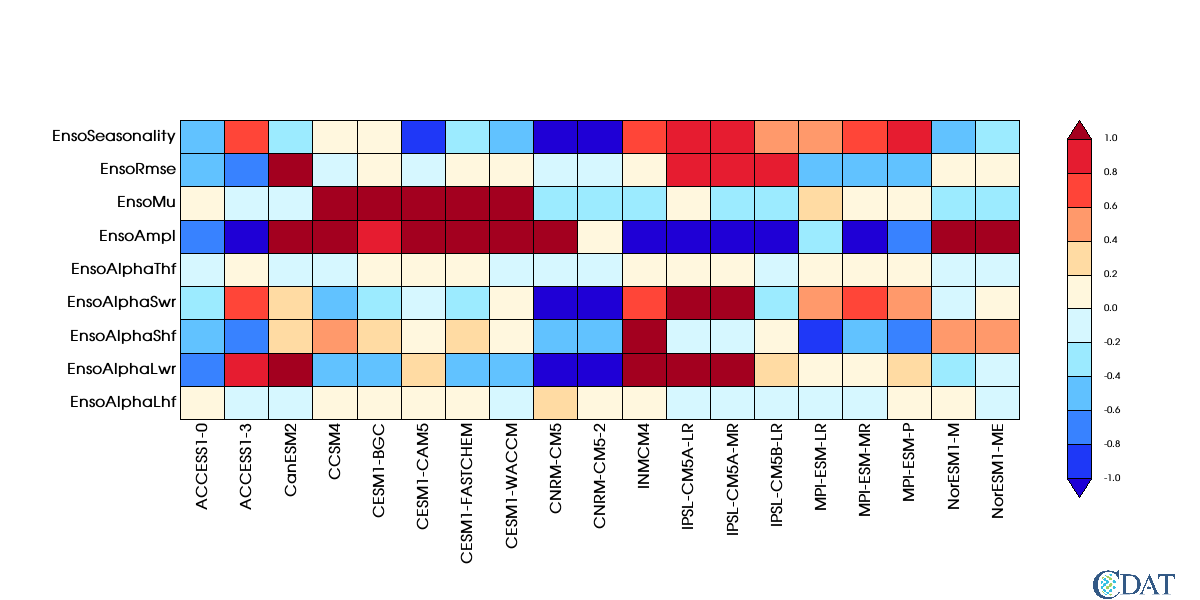

In [16]:
SET = P.PLOT_SETTINGS

# Viewport on the Canvas
SET.x1 = .15
SET.x2 = .85
SET.y1 = .3
SET.y2 = .8

# Both X (horizontal) and y (VERTICAL) ticks
# Text table
SET.tictable = vcs.createtexttable()
SET.tictable.color="black"

# X (bottom) ticks
# Text Orientation
SET.xticorientation = vcs.createtextorientation()
SET.xticorientation.angle = -90
SET.xticorientation.halign="right"
SET.xticorientation.height = 20

# Y (vertical) ticks
SET.yticorientation = vcs.createtextorientation()
SET.yticorientation.angle = 0
SET.yticorientation.halign="right"
SET.yticorientation.height = 20

# Parameters
#SET.parameterorientation = vcs.createtextorientation()
#SET.parameterorientation.height = 60
#SET.parametertable = vcs.createtexttable()
#SET.parametertable.color = "blue"

# We can turn off the "grid"
SET.draw_mesh = "n"
SET.draw_mesh = "y"


# Control color for missing
#SET.missing_color = "light grey"
SET.missing_color = "grey"
#SET.missing_color = "white"

# Tics length
SET.xtic1.y1 = 0
SET.xtic1.y2 = 0

# Timestamp
SET.time_stamp = None

# Colormap
SET.colormap = "inferno"
SET.colormap = "default"
SET.colormap = "rainbow"
SET.colormap = "bl_to_darkred"

# level to use
#SET.levels = [-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.5]
SET.levels = [-1., -.8, -.6,-.4,-.2,0,.2,.4,.6,.8,1.]
SET.levels.insert(0,-1.e20)
SET.levels.append(1.e20)

# colors to use
SET.fillareacolors = vcs.getcolors(SET.levels,split=0,colors=range(16,240))

x.clear()
P.plot(rms_xy,x=x)
show()

In [17]:
x.png('ENSO_PP.png')

## Annotated Plot 

NPARAM: 3


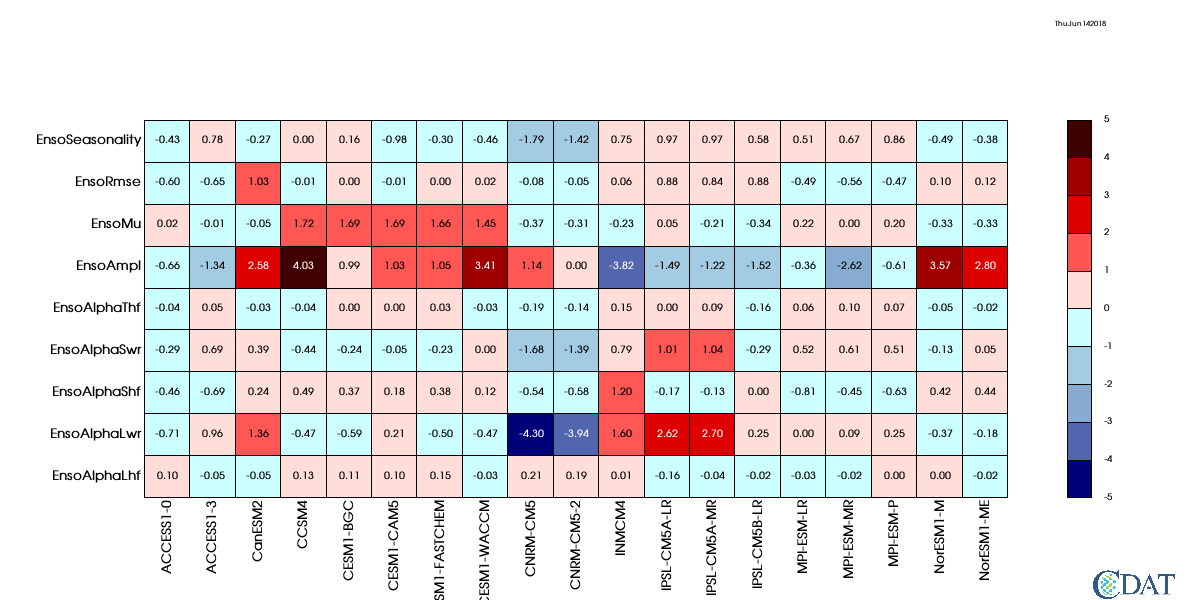

In [18]:
# PARAMETERS STUFF
P = pcmdi_metrics.graphics.portraits.Portrait()

P.PLOT_SETTINGS.values.show = True
#P.PLOT_SETTINGS.values.text.angle = -45
#P.PLOT_SETTINGS.values.lightcolor = "green"
#P.PLOT_SETTINGS.values.darkcolor = "red"

P.PLOT_SETTINGS.draw_mesh = "y"
#P.PLOT_SETTINGS.colormap = "bl_to_darkred"

P.PLOT_SETTINGS.xticorientation.height = 18
P.PLOT_SETTINGS.yticorientation.height = 18

x.clear()
P.plot(rms_xy,x=x)
show()